In [51]:
pip install prophet

     ---------------------------------------- 12.1/12.1 MB 9.2 MB/s eta 0:00:00
  Using cached convertdate-2.4.0-py3-none-any.whl (47 kB)
  Using cached holidays-0.21.13-py3-none-any.whl (378 kB)
     ---------------------------------------- 83.2/83.2 kB 4.6 MB/s eta 0:00:00
  Using cached LunarCalendar-0.0.9-py2.py3-none-any.whl (18 kB)
  Using cached hijri_converter-2.2.4-py3-none-any.whl (14 kB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import random as rd

import warnings
import datetime 
#$
import statsmodels.tsa.api as smt
import statsmodels.api as sn
from statsmodels.tsa.stattools import adfuller




#$warnings.filterwarnings('ignore')



In [3]:
from prophet import Prophet

In [6]:
data=pd.read_csv('files/google-data.csv')
df=data.copy()
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,357.385559,361.151062,355.959839,359.288177,359.288177,5115500
1,2013-01-03,360.122742,363.600128,358.031342,359.496826,359.496826,4666500
2,2013-01-04,362.313507,368.339294,361.488861,366.600616,366.600616,5562800
3,2013-01-07,365.348755,367.301056,362.929504,365.001007,365.001007,3332900
4,2013-01-08,365.393463,365.771027,359.874359,364.280701,364.280701,3373900


In [7]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [9]:
df['date']=pd.to_datetime(df['Date']).dt.strftime("%d/%m/%y")
df.drop('Date',inplace=True,axis=1)

In [11]:
data=pd.DataFrame() #sql left join mentiqi
data['date']=pd.date_range(start='2013-01-02',end='2017-12-29')
data['date']=data['date'].dt.strftime("%d/%m/%y")
data=data.merge(df,how='left',on='date')

In [13]:
data.head()

,date,Open,High,Low,Close,Adj Close,Volume
0,02/01/13,357.385559,361.151062,355.959839,359.288177,359.288177,5.115500e+06
1,03/01/13,360.122742,363.600128,358.031342,359.496826,359.496826,4.666500e+06
2,04/01/13,362.313507,368.339294,361.488861,366.600616,366.600616,5.562800e+06
3,05/01/13,363.672264,370.177059,364.091857,369.244832,369.244832,5.329146e+06
4,06/01/13,364.524566,369.314551,364.813292,367.666599,367.666599,4.257799e+06


ARROW kitabxanasi data ile isi asanlasdirir. TimeSeries ucun yaxsidi

In [12]:
numeric_columns=["Open","High","Low","Close","Adj Close","Volume"]
for n_col in numeric_columns:
    data[n_col]=data[n_col].interpolate(method='cubic') ## nan doldurmaq ucun
    

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1823 entries, 0 to 1822
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       1823 non-null   object 
 1   Open       1823 non-null   float64
 2   High       1823 non-null   float64
 3   Low        1823 non-null   float64
 4   Close      1823 non-null   float64
 5   Adj Close  1823 non-null   float64
 6   Volume     1823 non-null   float64
dtypes: float64(6), object(1)
memory usage: 113.9+ KB


In [20]:
data['Close']

0        359.288177
1        359.496826
2        366.600616
3        369.244832
4        367.666599
           ...     
1818    1060.584585
1819    1056.739990
1820    1049.369995
1821    1048.140015
1822    1046.400024
Name: Close, Length: 1823, dtype: float64

In [ ]:
a=sn.tsa.seasonal_decompose(data.Close.values, freq=365,model="additive")

In [1]:
m=sn.tsa.seasanal_decompose(data.Close.values, periods=365,model="multiclative")

NameError: name 'sn' is not defined

In [ ]:
fig=a.plot()

In [ ]:
fig1=m.plot()

### Stasionar deyil

In [29]:
def st_check(timeseries):
    dftest=adfuller(timeseries,autolag='AIC') # ADF Test
    dfoutput=pd.Series(dftest[0:4],index=['Test Statistics','p-value','#Lags Used','Number of'])
    
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key]=value
    print(dfoutput)

st_check(data.Close)

Test Statistics           -0.232731
p-value                    0.934506
#Lags Used                 5.000000
Number of               1817.000000
Critical Value (1%)       -3.433954
Critical Value (5%)       -2.863132
Critical Value (10%)      -2.567618
dtype: float64


### Autocorrelation and Partial Autocorrelation

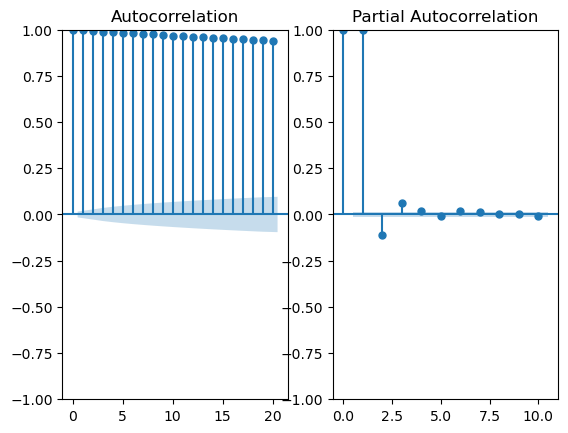

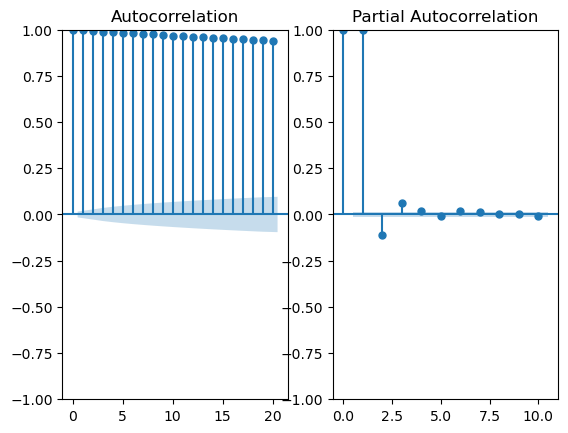

In [35]:
## 20 gun evvel bas vermis prosesin indrect olaraq 90% cox bu gunki bas vermis hadiseye tesiri var
## Sebebi datasetde trendin cox guclu olmasidir

## Bu bize insight verirki bu stock market uzerinde prediction vermek asan olacaq

## direct tesir azalir, indirect guclenir

## CS prime example of how inderect affect is regulated

## Pis terefi: uzun vadeli trendleri pis tapacaq

l=(1,2)
a=plt.subplot2grid(l,(0,0))
p=plt.subplot2grid(l,(0,1))

smt.graphics.plot_acf(data['Close'], lags=20, ax=a,alpha=0.5) # MA_indirect
smt.graphics.plot_pacf(data['Close'], lags=10, ax=p,alpha=0.5) # AR_direct

In [37]:
model_df=data.loc[:,['date','Close']].rename(columns={"date":"ds","Close":"y"})

#### model_df

### Prophet

In [54]:
model=Prophet(yearly_seasonality=True, interval_width=0.95)
model.fit(model_df)

14:27:06 - cmdstanpy - INFO - Chain [1] start processing
14:27:07 - cmdstanpy - INFO - Chain [1] done processing


In [55]:
ft=model.make_future_dataframe(periods=100)
pred=model.predict(ft)
pred[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1918,2018-04-04,1081.288660,988.446384,1174.430960
1919,2018-04-05,1082.644847,994.912544,1175.356580
1920,2018-04-06,1080.755801,986.792441,1170.038270
1921,2018-04-07,1080.478156,987.435063,1169.092713
1922,2018-04-08,1080.562395,990.958564,1171.025645


Text(0.5, 1.0, 'Google Stock Prices')

<Figure size 1600x800 with 0 Axes>

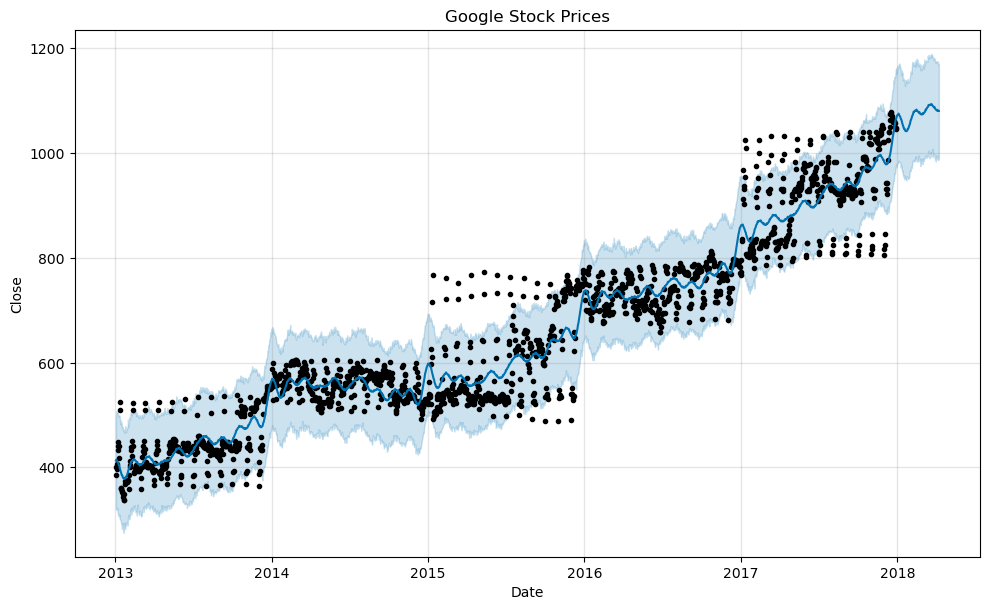

In [56]:
plt.figure(figsize=(16,8))
model.plot(pred,xlabel="Date",ylabel="Close")
plt.title("Google Stock Prices")

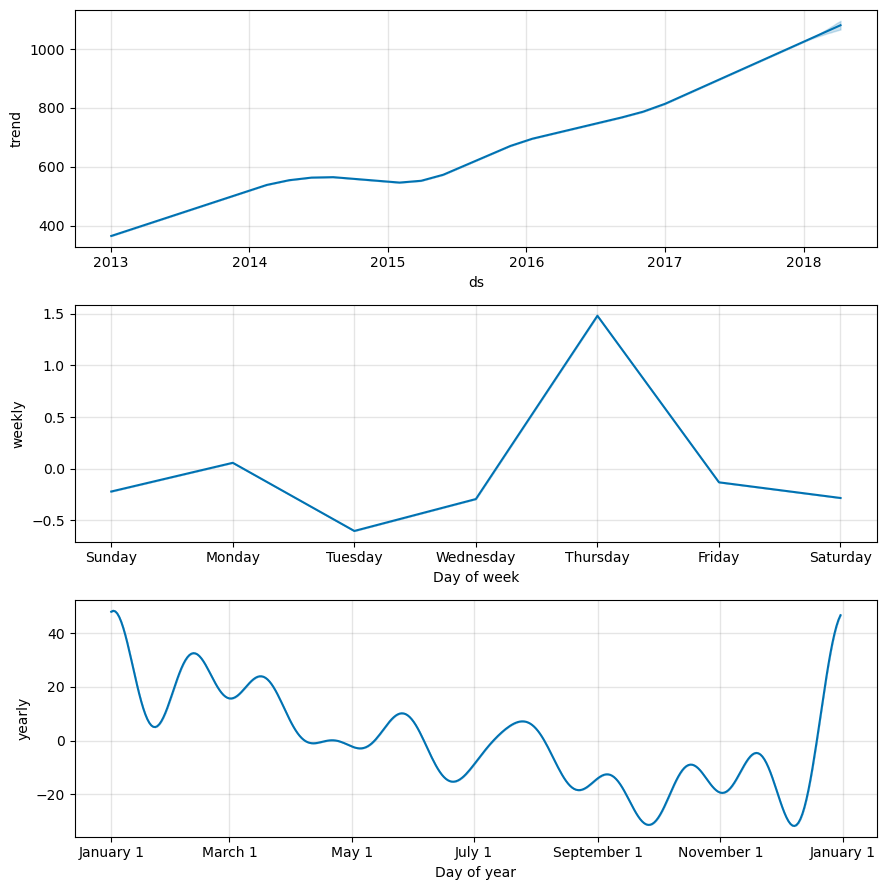

In [58]:
fig=model.plot_components(pred)